In [1]:
from astropy import constants as const
from scipy.stats import stats
import scipy.integrate as integrate
from scipy.stats import norm
from scipy import interpolate
from astropy.io import fits
from astropy import units as u
from iminuit import Minuit
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pysynphot as S
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0    

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


# Cadence LMC baseline v1

In [3]:
df = pd.read_csv("Downloads\Cadences dobservation des nuages de Magellan/cadence_lmc_baseline_v1.csv", index_col=0)
df

,observationId,night,observationStartMJD,fiveSigmaDepth,filter,airmass,skyBrightness,seeingFwhmEff,fieldId,fieldRA,fieldDec
0,934,1,59854.385463,21.593537,y,1.240813,18.077206,1.283730,-1,81.586959,-66.516554
1,936,1,59854.386287,21.510902,y,1.289795,17.976992,1.313900,-1,82.257779,-69.379108
2,937,1,59854.386702,21.432884,y,1.346227,17.894386,1.348096,-1,83.188050,-72.229967
3,3045,4,59857.362131,22.986090,z,1.382600,19.148145,0.881487,-1,80.811831,-73.766990
4,3103,4,59857.386839,22.764444,z,1.237434,18.602993,0.854189,-1,82.308664,-66.330677
...,...,...,...,...,...,...,...,...,...,...,...
891,2060333,3447,63269.058829,23.475867,u,1.278024,22.608174,1.180799,-1,85.471063,-68.743581
892,2060366,3447,63269.074276,24.549840,g,1.394360,22.091690,1.028710,-1,83.849276,-74.182487
893,2060368,3447,63269.075104,24.647890,g,1.282391,22.138014,0.978318,-1,85.471063,-68.743581
894,2062061,3449,63271.110220,23.578175,u,1.275128,22.621678,1.079728,-1,84.404241,-65.817402


# Histograms

Text(0.5, 0, 'skyBrightness')

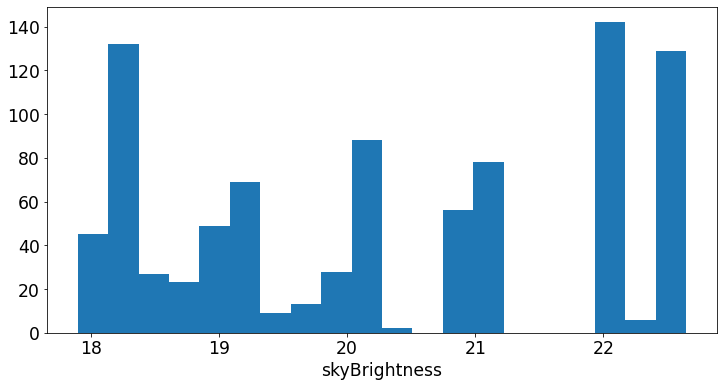

In [4]:
plt.hist(df['skyBrightness'], bins = 20);
plt.xlabel("skyBrightness")

# t0 distribution

Text(0.5, 1.0, 'Distribution des $t_0$')

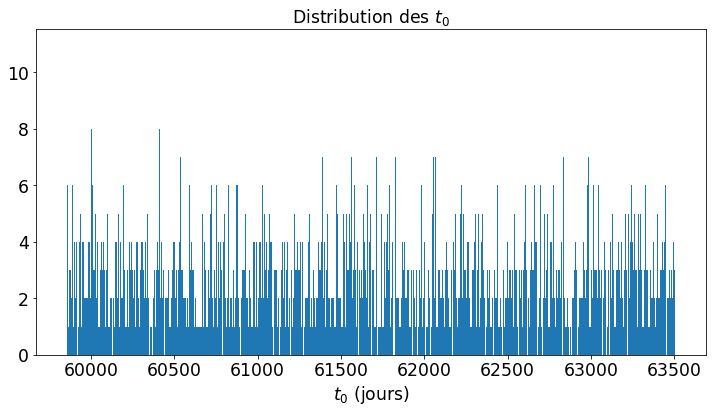

In [5]:
from scipy.stats import uniform

NYEARS = 10
NDAYS = NYEARS*365.25

xmin = 0
xmax = NDAYS
N=10000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N) + df['observationStartMJD'][0]

plt.hist(list_t0,bins=int(NDAYS));
plt.xlabel("$t_0$ (jours)")
plt.title("Distribution des $t_0$")

# u0 distribution

Text(0.5, 1.0, 'Densité de probabilité de $u_{min}$')

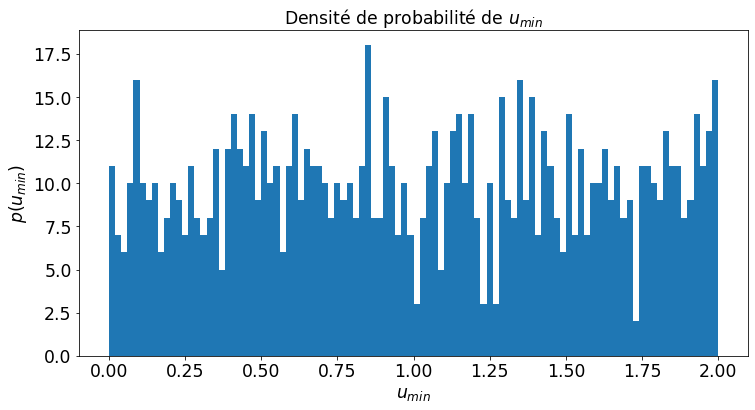

In [6]:
N = 1000
uminmin = 0
uminmax = 2
umin = uniform.rvs(uminmin,uminmax,N)

plt.hist(umin,bins=100)
plt.xlabel("$u_{min}$")
plt.ylabel("$p(u_{min})$")
plt.title("Densité de probabilité de $u_{min}$")

# Define LMC coordinates

In [7]:
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad

In [8]:
result_table = Simbad.query_object("lmc")

In [9]:
galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
print(galaxy_ra,galaxy_dec)

80.89416666666666 -69.75611111111111


### 

 - We choose data points in a 3.5° field around the center of the LMC

In [10]:
from photutils.aperture import SkyCircularAperture
from regions import CircleSkyRegion

positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg').galactic
aper = SkyCircularAperture(positions, 3.5 * u.deg)
Circle = CircleSkyRegion(positions, 3.5 * u.deg)

In [11]:
data_coords = []
data_coords_u = []
data_coords_g = []
data_coords_r = []
data_coords_i = []
data_coords_z = []
data_coords_y = []
gal_u = []
gal_g = []
gal_r = []
gal_i = []
gal_z = []
gal_y = []

for i in range (len(df['observationStartMJD'])) :
    
    data_coords.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
    
    if (df["filter"][i] == "u") :
        
        data_coords_u.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_u.append(data_coords[i].galactic)
   
    elif (df["filter"][i] == "g") :
        
        data_coords_g.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_g.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "r") :
        
        data_coords_r.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_r.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "i") :
        
        data_coords_i.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_i.append(data_coords[i].galactic)
           
    elif (df["filter"][i] == "z") :
        
        data_coords_z.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_z.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "y") :
        
        data_coords_y.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_y.append(data_coords[i].galactic)
        

# Sky map of the data points in galactic coordinates 

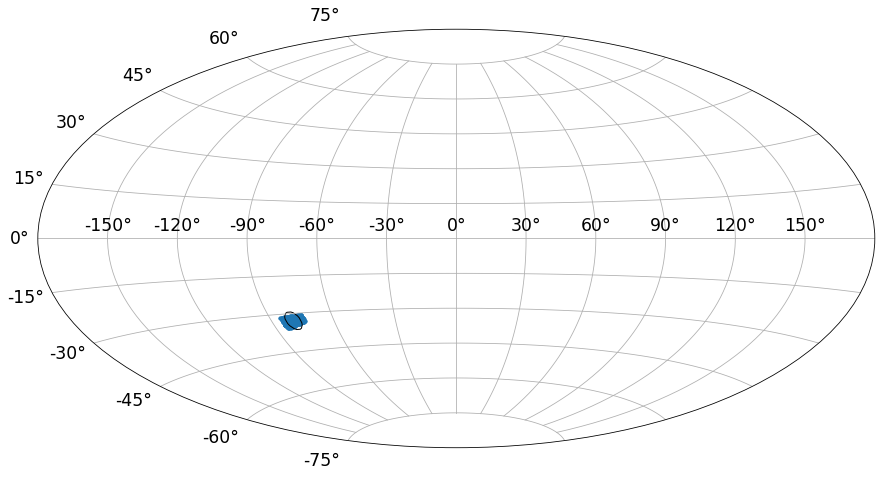

In [12]:
Circle_1 = plt.Circle((positions.l.wrap_at('180d').radian, positions.b.radian), 3.5*np.pi/180, fill = False)
gal = SkyCoord(df['fieldRA'], df['fieldDec'], unit='deg').galactic
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(projection='aitoff')
ax.add_patch(Circle_1)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, color='C0', alpha=1, marker='.')
plt.grid();

# Sky map of the data points in galactic coordinates (with colors for each filters)

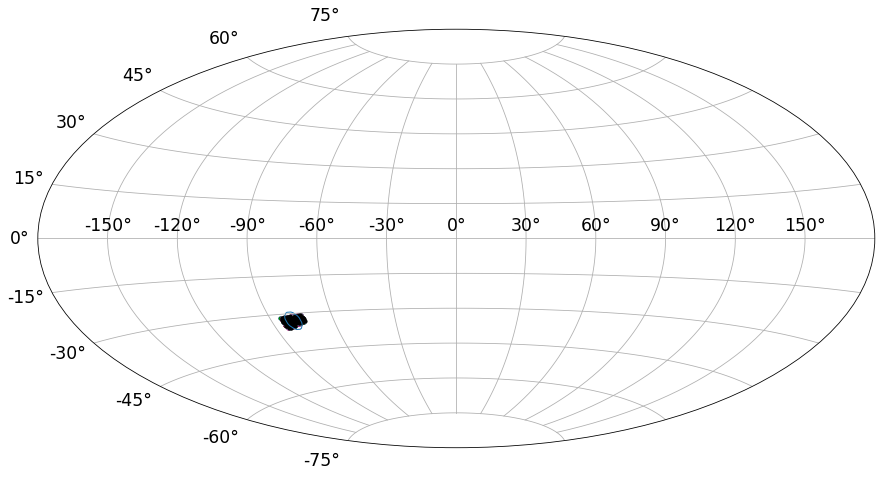

In [13]:
fig = plt.figure(figsize=(15, 10))
Circle_1 = plt.Circle((positions.l.wrap_at('180d').radian, positions.b.radian), 3.5*np.pi/180, fill = False, color ='C0')
ax = plt.subplot(projection='aitoff')
ax.add_patch(Circle_1)

for i in range (len(gal_u)) :

    plt.scatter(gal_u[i].l.wrap_at('180d').radian, gal_u[i].b.radian, color ='b', alpha=1, marker='.')
    
for i in range (len(gal_g)) :
    
    plt.scatter(gal_g[i].l.wrap_at('180d').radian, gal_g[i].b.radian, color = "g", alpha=1, marker='.')
    
for i in range (len(gal_r)) :
    
    plt.scatter(gal_r[i].l.wrap_at('180d').radian, gal_r[i].b.radian, color = "r", alpha=1, marker='.')
    
for i in range (len(gal_i)) :
    
    plt.scatter(gal_i[i].l.wrap_at('180d').radian, gal_i[i].b.radian, color = "blueviolet", alpha=1, marker='.')
    
for i in range (len(gal_z)) :
    
    plt.scatter(gal_z[i].l.wrap_at('180d').radian, gal_z[i].b.radian, color = "grey", alpha=1, marker='.')
    
for i in range (len(gal_y)) :
    
    plt.scatter(gal_y[i].l.wrap_at('180d').radian, gal_y[i].b.radian, color = "k", alpha=1, marker='.')

plt.grid();

In [14]:
from astropy.wcs import WCS
from astropy.wcs.utils import wcs_to_celestial_frame

In [15]:
File = fits.open(r'D:\Projet de recherche\Stage\skv20135441655710.fits')

image = File[0].data
header = File[0].header
wcs = WCS(header)
#hpc_frame = wcs_to_celestial_frame(wcs)
#center = SkyCoord(galaxy_ra * u.degree, galaxy_dec * u.degree, frame=hpc_frame)

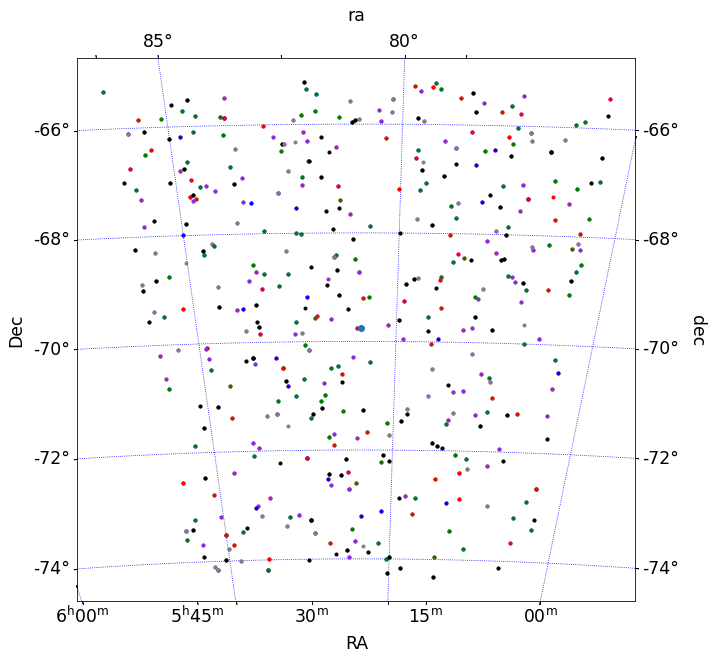

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection = wcs)
#plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')
#Circle_2 = plt.Circle((galaxy_ra, galaxy_dec), 3.5, fill = False, color ='C0')
#ax.add_patch(Circle_2)

for i in range (len(df['observationId'])) :

    if (df['filter'][i] == "u") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='.')
        
    if (df['filter'][i] == "g") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='.')
        
    if (df['filter'][i] == "r") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='.')
        
    if (df['filter'][i] == "i") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='.')
        
    if (df['filter'][i] == "z") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='.')
        
    if (df['filter'][i] == "y") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='.')
    
ax.plot_coord(SkyCoord(galaxy_ra * u.deg, galaxy_dec * u.deg), marker = 'o')   
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='blue', ls='dotted')

In [75]:
df_test = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]

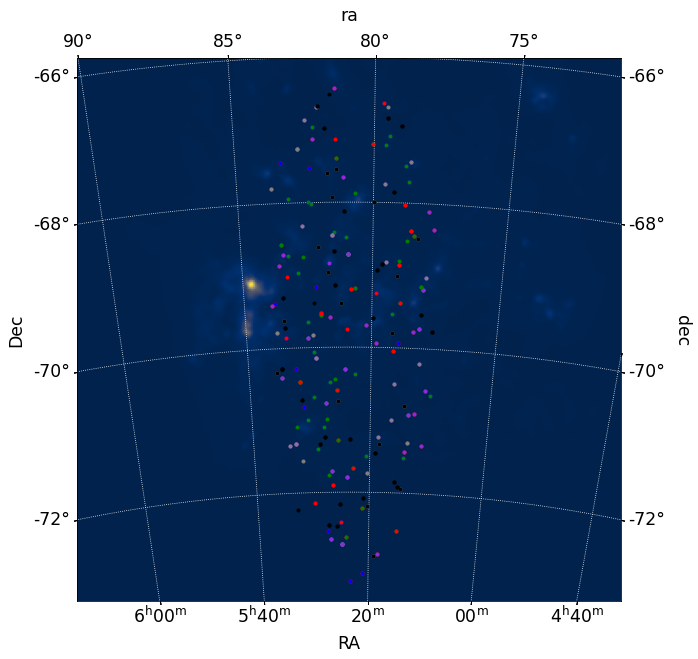

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection = wcs)
plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')   
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')


for i in range (len(df['observationId'])) :

    if (df['filter'][i] == 'u' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='.')
        
    if (df['filter'][i] == 'g' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='.')
        
    if (df['filter'][i] == 'r' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='.')
        
    if (df['filter'][i] == 'i' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='.')
        
    if (df['filter'][i] == 'z' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='.')
        
    if (df['filter'][i] == 'y' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='.')
        
# 7.5° image

# Plot of the data points coordinates (RA, Dec) and the LSST field of view ( 3.5° circle around the center of the LMC)

Text(0, 0.5, 'Declination')

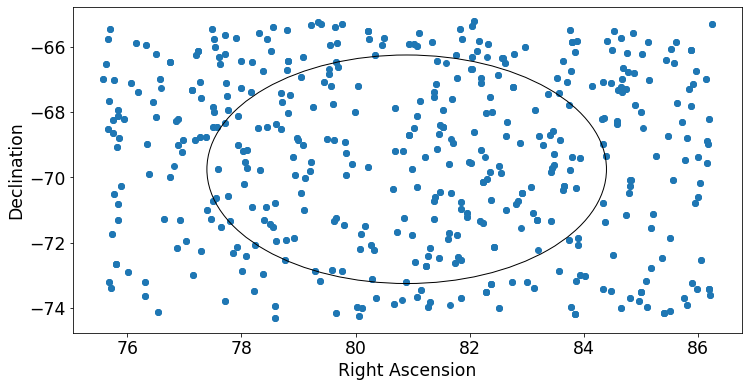

In [19]:
Circle_3 = plt.Circle((galaxy_ra, galaxy_dec), 3.5, fill = False)
fig, ax = plt.subplots() 
plt.scatter(df['fieldRA'], df['fieldDec'])
ax.add_patch(Circle_3)
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

# We only keep the data points inside the LSST field of view  

Text(0, 0.5, 'Declination')

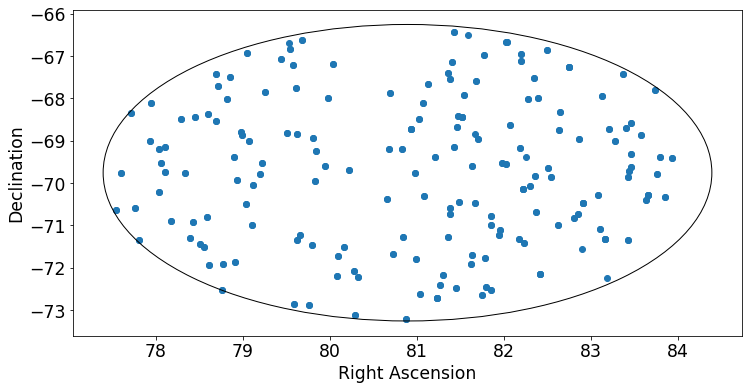

In [20]:
Circle_3 = plt.Circle((galaxy_ra, galaxy_dec), 3.5, fill = False)
fig, ax = plt.subplots() 
plt.scatter(df_test['fieldRA'], df_test['fieldDec'])
ax.add_patch(Circle_3)
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

# Relative angular source-lens separation u(t)

$$ 
   u(t) = \sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2)}
$$




In [60]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

# Amplitude as a function of u(t)

$$
    A(u) = \frac{u^2 + 2}{u\sqrt{u^2 + 4}}
$$

In [61]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

# Amplitude as a function of u0, t0, tE

$$
    A(t, u_0, t_0, t_E) = \frac{u_{0}^2 + (\frac{t-t_0}{t_E})^2) + 2}{\sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2)} \sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2) + 4}}
$$

In [23]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4) 

# Gaussian

$$
    y = \frac{A}{\sigma \sqrt{2\pi}} e^{\frac{-(x - \mu)^2}{2\sigma^2}}
$$

In [24]:
#Gaussian fit

def Gauss(x, A, mu ,sigma) :
    return A*np.exp(-(x-mu)**2/(2*sigma**2))/sigma/np.sqrt(2*np.pi)

# Linear 

$$
    y = \alpha x + \beta
$$


In [25]:
#Linear fit

def linear(x, alpha, beta) : 
    return alpha*x + beta

# Plotting the light curve and Microlensing fit with arbitrary errors

t0 = 60559.11744081887
tE = 20
u0 = 0.7802377977402184


(60459.11744081887, 60659.11744081887)

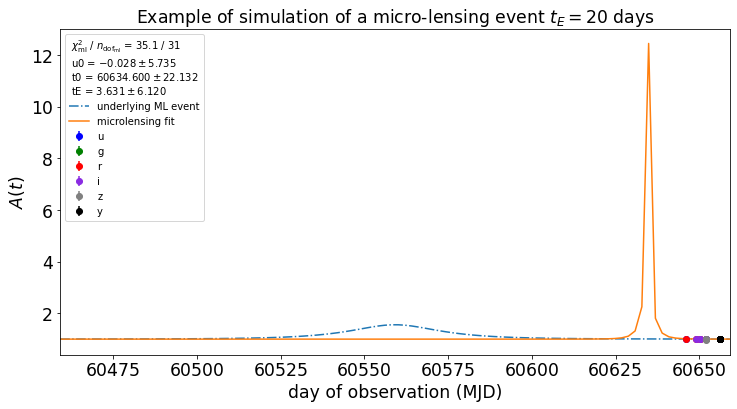

In [26]:
#Randomize parameters

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 20

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Plot

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")
#plt.scatter(df_event_times,A(u(df_event_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_u_times,A(u(df_event_u_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_g_times,A(u(df_event_g_times)),marker="o",s=20,color = "g",label="g")
#plt.scatter(df_event_r_times,A(u(df_event_r_times)),marker="o",s=20,color = "r",label="r")
#plt.scatter(df_event_i_times,A(u(df_event_i_times)),marker="o",s=20,color ="blueviolet",label="i")
#plt.scatter(df_event_z_times,A(u(df_event_z_times)),marker="o",s=20,color ="grey",label="z")
#plt.scatter(df_event_y_times,A(u(df_event_y_times)),marker="o",s=20,color="k",label="y")

# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

y_noise = 0.01

y = y_data + y_noise * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + y_noise * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + y_noise * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + y_noise * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + y_noise * np.random.randn(len(x_i)) 
y_z = A(u(df_event_times_z)) + y_noise * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + y_noise * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, y_noise, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, y_noise, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, y_noise, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, y_noise, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, y_noise, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, y_noise, fmt="o", label="y", color ="k")

least_squares = LeastSquares(x, y, y_noise, Ab)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Ab(ti, *m.values), label="microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

# Linear fit

(60459.11744081887, 60659.11744081887)

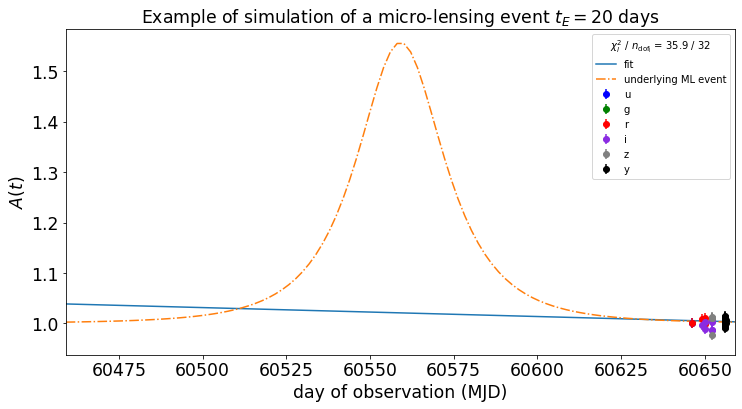

In [27]:
least_squares_line = LeastSquares(x, y, y_noise, linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, y_noise, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, y_noise, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, y_noise, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, y_noise, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, y_noise, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, y_noise, fmt="o", label="y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label="fit")
plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [28]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit)) 

0.09955335686269177

# Test error 

In [29]:

m = 20
xerr = []
sigma_sys = 0.003
error_photo = []


for i in range (len(df)) :
    
    xerr.append( 10**(0.4*(m - df["fiveSigmaDepth"][i])))
    
    if (df["filter"][i] == "u") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.037) * xerr[i] + 0.037 * xerr[i]**2))  
   
    elif (df["filter"][i] == "g") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.038) * xerr[i] + 0.038 * xerr[i]**2))  
        
    elif (df["filter"][i] == "r") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))  
        
    elif (df["filter"][i] == "i") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))      
           
    elif (df["filter"][i] == "z") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))     
        
    elif (df["filter"][i] == "y") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))
        


# Photo error as a function of magnitude

Text(0.5, 1.0, 'Photometric error as a function of magnitude')

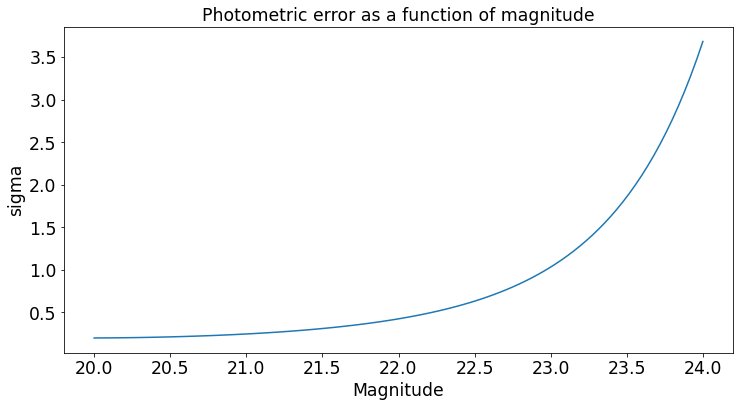

In [30]:
mag = np.linspace(20,24,100)
sigma = []

for i in range (len(mag)) :
    
    sigma.append(np.sqrt(sigma_sys**2 + (0.04 - 0.037) * 10**(0.4*(mag[i] - 20)) + 0.037 * 10**(0.4*(mag[i] - 20))**2))

    
plt.plot(mag,sigma)
plt.xlabel("Magnitude")
plt.ylabel("sigma")
plt.title("Photometric error as a function of magnitude")
#plt.text(x = 21, y = 3, s = "Low magnitude/Bright source means high photometric error", fontsize = 15, color = 'r')

# Background noise

$$
    F_b = F_{ab}10^{-0.4m_b} \times \pi \theta_{seeing}^2 
$$

$$
     F_{ab} = 3631 Jy = 3631\times10^{-23} erg.s^{-1}.Hz^{-1}.cm^{-2} = 3631\times10^{-26} W.Hz^{-1}.m^{-2}
$$

$$
    N_{pe}^b = \frac{\pi D^2 \Delta T}{4h}F_b \int_{}^{} T^{syst}_b(\lambda) \,\frac{d\lambda}{\lambda} 
$$

In [31]:
df_LSST = pd.read_csv("D:\\Projet de recherche\Stage\lsst_throughput.csv", index_col=0)

In [32]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)

In [33]:
ObservationStartMJD_u = []
ObservationStartMJD_g = []
ObservationStartMJD_r = []
ObservationStartMJD_i = []
ObservationStartMJD_z = []
ObservationStartMJD_y = []

for i in range (len(df["observationId"])) :
    
    if (df['filter'][i] == 'u') :
            
            ObservationStartMJD_u.append(df["observationStartMJD"].values[i])
    
    if (df['filter'][i] == 'g') :
            
            ObservationStartMJD_g.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'r') :
            
            ObservationStartMJD_r.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'i') :
            
            ObservationStartMJD_i.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'z') :
            
            ObservationStartMJD_z.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'y') :
        
            ObservationStartMJD_y.append(df["observationStartMJD"].values[i])

In [34]:
from astropy import units as u

D = Deff
Delta_T = EXPOSURE
F_ab = 3631*10**(-23) * u.erg/u.s/u.Hz/u.cm**2

In [35]:
F_ab.to(u.jansky)

<Quantity 3631. Jy>

In [36]:
H = S.units.H * (u.erg * u.s)
H

<Quantity 6.6262e-27 erg s>

In [37]:
F_b = []
F_b_u = []
F_b_g = []
F_b_r = []
F_b_i = []
F_b_z = []
F_b_y = []

for i in range (len(df["observationId"])) :
    
    F_b.append(F_ab * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
    
    if (df['filter'][i] == 'u') :
            
            F_b_u.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
    
    if (df['filter'][i] == 'g') :
            
            F_b_g.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'r') :
            
            F_b_r.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'i') :
            
            F_b_i.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'z') :
            
            F_b_z.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'y') :
        
            F_b_y.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))

Text(0.5, 0, 'Day of observation (MJD)')

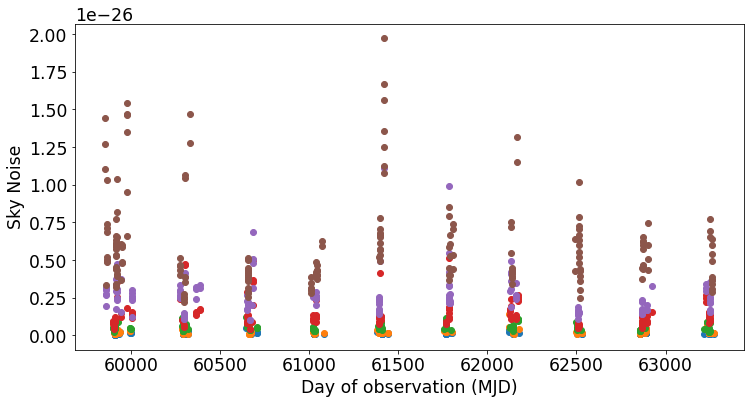

In [38]:
plt.scatter(ObservationStartMJD_u, F_b_u)
plt.scatter(ObservationStartMJD_g, F_b_g)
plt.scatter(ObservationStartMJD_r, F_b_r)
plt.scatter(ObservationStartMJD_i, F_b_i)
plt.scatter(ObservationStartMJD_z, F_b_z)
plt.scatter(ObservationStartMJD_y, F_b_y)
plt.ylabel("Sky Noise")
plt.xlabel("Day of observation (MJD)")

In [39]:
N_pe = []
N_pe_u = []
N_pe_g = []
N_pe_r = []
N_pe_i = []
N_pe_z = []
N_pe_y = []

for i in range (len(F_b)) :
    
    if (df['filter'][i] == 'u') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_u.throughput/Wavelength))
            N_pe_u.append(N_pe[i])
    
    if (df['filter'][i] == 'g') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_g.throughput/Wavelength))
            N_pe_g.append(N_pe[i])
            
    if (df['filter'][i] == 'r') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_r.throughput/Wavelength))
            N_pe_r.append(N_pe[i])
            
    if (df['filter'][i] == 'i') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_i.throughput/Wavelength))
            N_pe_i.append(N_pe[i])
            
    if (df['filter'][i] == 'z') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_z.throughput/Wavelength))
            N_pe_z.append(N_pe[i])
            
    if (df['filter'][i] == 'y') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_y.throughput/Wavelength))
            N_pe_y.append(N_pe[i])


Text(0.5, 0, 'Day of observation (MJD)')

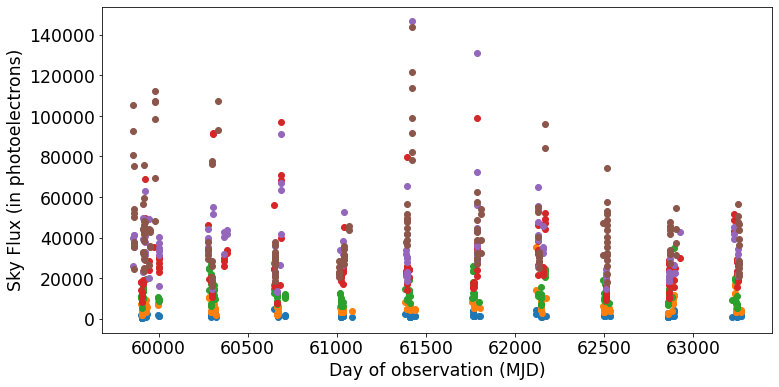

In [40]:
plt.scatter(ObservationStartMJD_u, N_pe_u)
plt.scatter(ObservationStartMJD_g, N_pe_g)
plt.scatter(ObservationStartMJD_r, N_pe_r)
plt.scatter(ObservationStartMJD_i, N_pe_i)
plt.scatter(ObservationStartMJD_z, N_pe_z)
plt.scatter(ObservationStartMJD_y, N_pe_y)
plt.ylabel("Sky Flux (in photoelectrons)")
plt.xlabel("Day of observation (MJD)")

In [41]:
#import scipy.integrate as integrate
#a = 0

#for i in range (len(LSST_u.throughput)) :
    
    #a = integrate.quad(lambda Wavelength: LSST_u.throughput[i]/Wavelength, 3000, 12000)
    
#a

In [42]:
integrate.trapz(LSST_u.throughput/Wavelength)

0.006519157490141833

In [43]:
a = 0

for i in range (len(LSST_u.throughput)) :
    
    a = a + LSST_u.throughput[i]/Wavelength[i]
    
a

0.006519276406808502

In [44]:
agk_81d266 = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'agk_81d266_stisnic_007.fits')

agk_81d266_spec = S.FileSpectrum(agk_81d266).renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

agk_81d266_spec.convert('count')

(0.0, 6000.0)

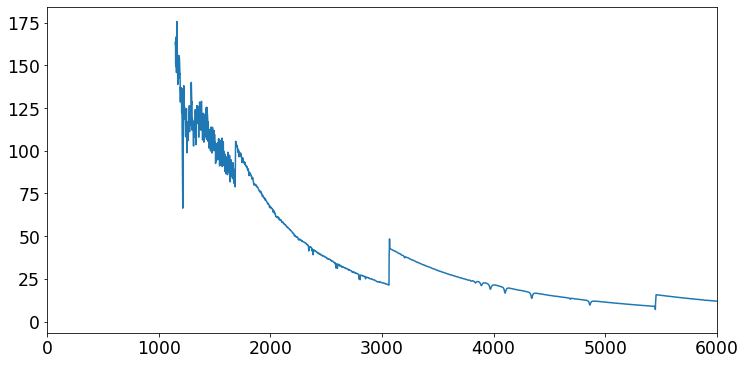

In [45]:
plt.plot(agk_81d266_spec.wave, agk_81d266_spec.flux)
plt.xlim([0,6000])

# Atmospheric throughput for every observation

In [46]:
import transmission as t

t.atmo(4959,1.2584)

0.86480181472

In [47]:
df_2018a = pd.read_csv(r'D:\Projet de recherche\Stage\Baseline_LMCv1_Atmosphere.csv')
df_2018a

,1,2,3,4,5,6,7,8,9,10,...,887,888,889,890,891,892,893,894,895,896
3000,0.009290,0.007645,0.006239,0.005402,0.009404,0.005323,0.007454,0.009175,0.007973,0.006507,...,0.005234,0.006587,0.008061,0.009584,0.005245,0.008040,0.005131,0.007894,0.008138,0.007270
3010,0.014854,0.012475,0.010382,0.009125,0.015018,0.009006,0.012198,0.014687,0.012949,0.010785,...,0.008873,0.010905,0.013077,0.015279,0.008890,0.013047,0.008718,0.012834,0.013187,0.011931
3020,0.021952,0.018749,0.015862,0.014115,0.022173,0.013950,0.018377,0.021728,0.019387,0.016422,...,0.013765,0.016589,0.019560,0.022525,0.013788,0.019519,0.013550,0.019233,0.019708,0.018014
3030,0.035094,0.030581,0.026392,0.023836,0.035406,0.023594,0.030057,0.034779,0.031481,0.027211,...,0.023323,0.027456,0.031724,0.035901,0.023357,0.031666,0.023009,0.031264,0.031933,0.029543
3040,0.041745,0.036646,0.031861,0.028932,0.042097,0.028655,0.036054,0.041389,0.037662,0.032800,...,0.028344,0.033080,0.037937,0.042657,0.028384,0.037872,0.027985,0.037417,0.038173,0.035471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11960,0.972714,0.971665,0.970460,0.969685,0.972787,0.969611,0.971543,0.972641,0.971874,0.970709,...,0.969529,0.970783,0.971931,0.972902,0.969539,0.971917,0.969434,0.971824,0.971979,0.971416
11970,0.972714,0.971665,0.970460,0.969685,0.972787,0.969611,0.971543,0.972641,0.971874,0.970709,...,0.969529,0.970783,0.971931,0.972902,0.969539,0.971917,0.969434,0.971824,0.971979,0.971416
11980,0.955584,0.953960,0.952106,0.950914,0.955696,0.950801,0.953771,0.955470,0.954283,0.952488,...,0.950675,0.952602,0.954371,0.955874,0.950691,0.954350,0.950529,0.954205,0.954446,0.953575
11990,0.955584,0.953960,0.952106,0.950914,0.955696,0.950801,0.953771,0.955470,0.954283,0.952488,...,0.950675,0.952602,0.954371,0.955874,0.950691,0.954350,0.950529,0.954205,0.954446,0.953575


In [48]:
bp_atmo = []

for i in range (len(df['observationId'])) :
    
    #if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) :
        
    bp = S.ArrayBandpass(df_LSST["wl"].values*10, df_2018a.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp)

In [49]:
all_bp = []

for i in range (len(bp_atmo)) :

    if (df['filter'][i] == 'u') :
        
        bp = LSST_u * bp_atmo[i]
        all_bp.append(bp)
        
    elif (df['filter'][i] == 'g') :
        
        bp = LSST_g * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'r') :
        
        bp = LSST_r * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'i') :
        
        bp = LSST_i * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'z') :
        
        bp = LSST_z * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'y') :
        
        bp = LSST_y * bp_atmo[i]
        all_bp.append(bp)

# Define the source spectrum below

In [50]:
Spec = S.Vega.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

In [51]:
all_obs = []

for bp in all_bp :
    
    obs = S.Observation(Spec, bp);
    all_obs.append(obs);

((y * Observation 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((z * Observation 67)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 68)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 69)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 70)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 71)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 72)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 73)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 74)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((g * Observation 131)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 132)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 133)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 134)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 135)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 136)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 137)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 138)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 195)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 196)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 197)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 198)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 199)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 200)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 201)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 202)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 329)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 330)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 331)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 332)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 333)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 334)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 335)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 336)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 394)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 395)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 396)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 397)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 398)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 399)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 400)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 401)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 461)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 462)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 463)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 464)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 465)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 466)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 467)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 468)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 525)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 526)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 527)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 528)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 529)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 530)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 531)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 532)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 657)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 658)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 659)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 660)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 661)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 662)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 663)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 664)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 721)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 722)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 723)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 724)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 725)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 726)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 727)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 728)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 788)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 789)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 790)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 791)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 792)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 793)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 794)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 795)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [52]:
all_count = []

for obs in all_obs :
    
    all_count.append(obs.countrate())

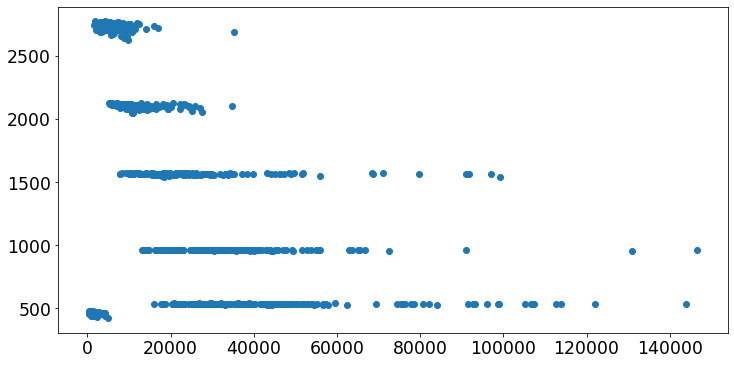

In [53]:
plt.scatter(N_pe, all_count)

In [54]:
#plt.scatter(df['observationStartMJD'], all_count_u, color = "b")
#plt.scatter(df['observationStartMJD'], all_count_g, color = "g")
#plt.scatter(df['observationStartMJD'], all_count_r, color = "r")
#plt.scatter(df['observationStartMJD'], all_count_i, color = "blueviolet")
#plt.scatter(df['observationStartMJD'], all_count_z, color = "grey")
#plt.scatter(df['observationStartMJD'], all_count_y, color = "k")

# Photometric error

$$
    N = \sqrt{N_{pe} + F}
$$

$$
    \sigma_N = \sqrt{N}
$$

where 

$N_{pe}$ is the background noise 

F is the source flux  

$\sigma_N$ the error

In [55]:
N = []

for i in range (len(bp_atmo)) :
    
    N.append(np.sqrt(N_pe[i] + all_count[i]))

In [56]:
sigma_N = []

for i in range (len(bp_atmo)) :
    
    sigma_N.append(np.sqrt(N[i]))

Text(0, 0.5, 'Photometric error')

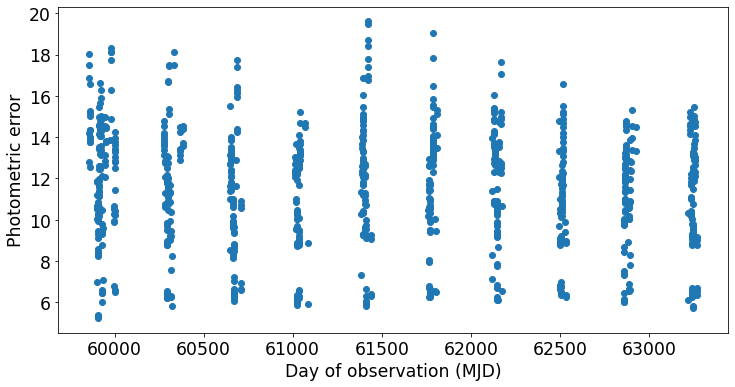

In [57]:
plt.scatter(df['observationStartMJD'], sigma_N)
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Photometric error")

<ErrorbarContainer object of 3 artists>

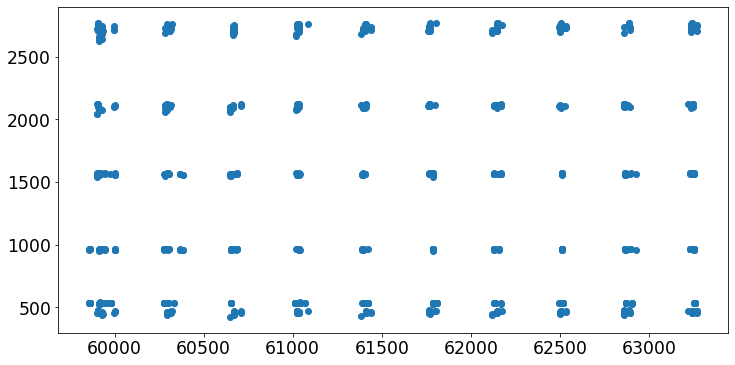

In [58]:
plt.errorbar(df['observationStartMJD'], all_count, sigma_N, fmt="o")

# Amplitude error

$$
\sigma_A = \frac{\sigma_N \times A(t)}{F}
$$

In [62]:
amp_err = []

for i in range (len(bp_atmo)) :
    
    amp_err.append(sigma_N[i] * A(u(df['observationStartMJD'][i]))/all_count[i])


# Plotting the light curve and Microlensing fit with expected errors

t0 = 60715.64282511517
tE = 20
u0 = 0.5488605843297083


(60615.64282511517, 60815.64282511517)

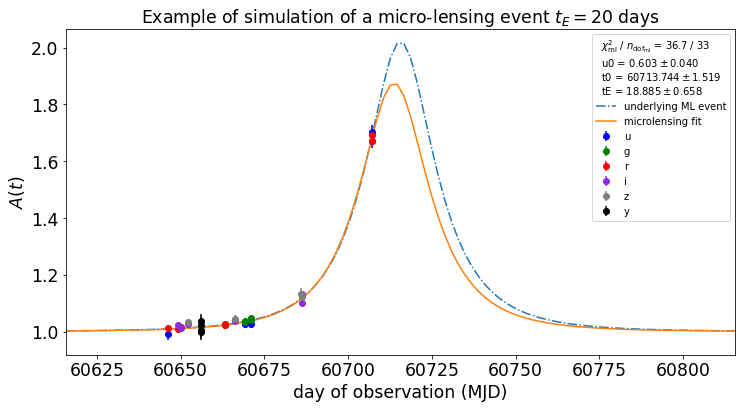

In [83]:
#Randomize parameters

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 20

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Photometric Error


    

amp_err = []
amp_err_u = []
amp_err_g = []
amp_err_r = []
amp_err_i = []
amp_err_z = []
amp_err_y = []

for i in range (len(df['observationStartMJD'])) :
    
    if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        amp_err.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
    
        if (df['filter'].values[i] == 'u') :
        
            
            amp_err_u.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
       
        if (df['filter'].values[i] == 'g') :
        
            
            amp_err_g.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'r') :
        
            
            amp_err_r.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'i') :
        
            
            amp_err_i.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'z') :
        
            
            amp_err_z.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'y') :
        
            
            amp_err_y.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
    



#Plot

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")
#plt.scatter(df_event_times,A(u(df_event_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_u_times,A(u(df_event_u_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_g_times,A(u(df_event_g_times)),marker="o",s=20,color = "g",label="g")
#plt.scatter(df_event_r_times,A(u(df_event_r_times)),marker="o",s=20,color = "r",label="r")
#plt.scatter(df_event_i_times,A(u(df_event_i_times)),marker="o",s=20,color ="blueviolet",label="i")
#plt.scatter(df_event_z_times,A(u(df_event_z_times)),marker="o",s=20,color ="grey",label="z")
#plt.scatter(df_event_y_times,A(u(df_event_y_times)),marker="o",s=20,color="k",label="y")

# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

y = y_data + amp_err * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + amp_err_u * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + amp_err_g * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + amp_err_r * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + amp_err_i * np.random.randn(len(x_i))
y_z = A(u(df_event_times_z)) + amp_err_z * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + amp_err_y * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")

least_squares = LeastSquares(x, y, amp_err, Ab)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Ab(ti, *m.values), label="microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [76]:
Circle.radius.value

3.5

(60615.64282511517, 60815.64282511517)

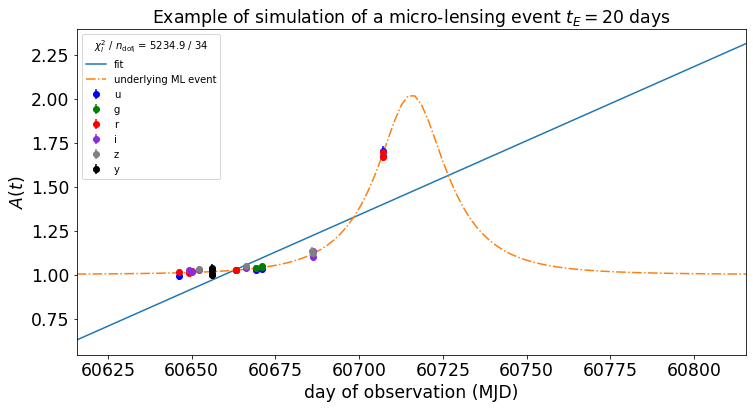

In [84]:
least_squares_line = LeastSquares(x, y, amp_err, linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label="fit")
plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [85]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit)) 

639.8543489284638